# 1. Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import os
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
%matplotlib inline
import pandas as pd 
import pandas_datareader as web 
import datetime
import statistics as stats
from statsmodels.stats import weightstats
from datetime import datetime

import sklearn.preprocessing as preproc
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.ForecasterAutoregMultiOutput import ForecasterAutoregMultiOutput
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster

from joblib import dump, load

import altair as alt
from bokeh.io import curdoc, output_notebook
from bokeh.plotting import figure, show
from bokeh.models import HoverTool, ColumnDataSource, CategoricalColorMapper, Slider
from bokeh.palettes import Spectral6
from bokeh.layouts import Column, row
import country_converter as coco
from pycountry import countries
from pycountry import pycountry
import plotly.express as px
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_model import ARIMA

# 2. Importing Dataset

In [2]:
df = pd.read_csv('UNE_EDUC_A.csv')


In [3]:
df.head(5)

,DATAFLOW,LAST UPDATE,freq,sex,isced11,age,unit,geo,TIME_PERIOD,OBS_VALUE,OBS_FLAG
0,ESTAT:UNE_EDUC_A(1.0),20/06/23 23:00:00,A,F,ED0-2,Y15-74,PC_ACT,AT,2013,9.6,NaN
1,ESTAT:UNE_EDUC_A(1.0),20/06/23 23:00:00,A,F,ED0-2,Y15-74,PC_ACT,AT,2014,10.4,NaN
2,ESTAT:UNE_EDUC_A(1.0),20/06/23 23:00:00,A,F,ED0-2,Y15-74,PC_ACT,AT,2015,10.0,NaN
3,ESTAT:UNE_EDUC_A(1.0),20/06/23 23:00:00,A,F,ED0-2,Y15-74,PC_ACT,AT,2016,11.3,NaN
4,ESTAT:UNE_EDUC_A(1.0),20/06/23 23:00:00,A,F,ED0-2,Y15-74,PC_ACT,AT,2017,11.6,NaN


In [4]:
df.shape

(13278, 11)

# Data Exploration

In [5]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13278 entries, 0 to 13277
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   DATAFLOW     13278 non-null  object 
 1   LAST UPDATE  13278 non-null  object 
 2   freq         13278 non-null  object 
 3   sex          13278 non-null  object 
 4   isced11      13278 non-null  object 
 5   age          13278 non-null  object 
 6   unit         13278 non-null  object 
 7   geo          13278 non-null  object 
 8   TIME_PERIOD  13278 non-null  int64  
 9   OBS_VALUE    13252 non-null  float64
 10  OBS_FLAG     864 non-null    object 
dtypes: float64(1), int64(1), object(9)
memory usage: 1.1+ MB
None


In [6]:
df.describe()

,TIME_PERIOD,OBS_VALUE
count,13278.000000,13252.000000
mean,2017.759452,21.509878
std,2.950340,17.302445
min,2013.000000,0.800000
25%,2015.000000,7.500000
50%,2018.000000,16.500000
75%,2021.000000,30.900000
max,2022.000000,76.100000


# Pre-Processing Data

## Data Cleaning

In [7]:
df.isnull().any()

DATAFLOW       False
LAST UPDATE    False
freq           False
sex            False
isced11        False
age            False
unit           False
geo            False
TIME_PERIOD    False
OBS_VALUE       True
OBS_FLAG        True
dtype: bool

In [8]:
df.isnull().sum()

DATAFLOW           0
LAST UPDATE        0
freq               0
sex                0
isced11            0
age                0
unit               0
geo                0
TIME_PERIOD        0
OBS_VALUE         26
OBS_FLAG       12414
dtype: int64

In [9]:
df.tail(5)

,DATAFLOW,LAST UPDATE,freq,sex,isced11,age,unit,geo,TIME_PERIOD,OBS_VALUE,OBS_FLAG
13273,ESTAT:UNE_EDUC_A(1.0),20/06/23 23:00:00,A,T,ED5-8,Y25-74,PC_UNE,SE,2022,29.6,NaN
13274,ESTAT:UNE_EDUC_A(1.0),20/06/23 23:00:00,A,T,ED5-8,Y25-74,PC_UNE,SI,2021,34.9,NaN
13275,ESTAT:UNE_EDUC_A(1.0),20/06/23 23:00:00,A,T,ED5-8,Y25-74,PC_UNE,SI,2022,32.6,NaN
13276,ESTAT:UNE_EDUC_A(1.0),20/06/23 23:00:00,A,T,ED5-8,Y25-74,PC_UNE,SK,2021,14.4,NaN
13277,ESTAT:UNE_EDUC_A(1.0),20/06/23 23:00:00,A,T,ED5-8,Y25-74,PC_UNE,SK,2022,12.9,NaN


In [10]:
df = df.drop(['OBS_FLAG','freq','LAST UPDATE', 'DATAFLOW'], axis =1)
df.head(5)

,sex,isced11,age,unit,geo,TIME_PERIOD,OBS_VALUE
0,F,ED0-2,Y15-74,PC_ACT,AT,2013,9.6
1,F,ED0-2,Y15-74,PC_ACT,AT,2014,10.4
2,F,ED0-2,Y15-74,PC_ACT,AT,2015,10.0
3,F,ED0-2,Y15-74,PC_ACT,AT,2016,11.3
4,F,ED0-2,Y15-74,PC_ACT,AT,2017,11.6


In [11]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13278 entries, 0 to 13277
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   sex          13278 non-null  object 
 1   isced11      13278 non-null  object 
 2   age          13278 non-null  object 
 3   unit         13278 non-null  object 
 4   geo          13278 non-null  object 
 5   TIME_PERIOD  13278 non-null  int64  
 6   OBS_VALUE    13252 non-null  float64
dtypes: float64(1), int64(1), object(5)
memory usage: 726.3+ KB
None


In [12]:
df.duplicated().sum()

0

In [13]:
df.isnull().sum()

sex             0
isced11         0
age             0
unit            0
geo             0
TIME_PERIOD     0
OBS_VALUE      26
dtype: int64

In [14]:
null_index = df[df['OBS_VALUE'].isnull()].index
print(null_index)

Int64Index([ 825,  826,  832,  834, 1159, 1160, 1166, 1168, 1365, 1366, 1382,
            1434, 1435, 1451, 7541, 7606, 7607, 7874, 7939, 7940, 8207, 8272,
            8273, 8540, 8605, 8606],
           dtype='int64')


In [15]:
# Filter out rows where 'OBS_VALUE' is missing
missing_values_df = df[df['OBS_VALUE'].isnull()]

# Group by 'TIME_PERIOD' and other categories to count missing values
missing_counts = missing_values_df.groupby(['TIME_PERIOD', 'unit', 'sex', 'age', 'isced11', 'geo']).size().reset_index(name='Missing_Count')

# Display the results
print(missing_counts)


    TIME_PERIOD    unit sex     age isced11 geo  Missing_Count
0          2015  PC_ACT   M  Y15-74   ED5-8  MT              1
1          2015  PC_ACT   M  Y20-64   ED5-8  MT              1
2          2015  PC_UNE   M  Y15-74   ED5-8  MT              1
3          2015  PC_UNE   M  Y20-64   ED5-8  MT              1
4          2016  PC_ACT   M  Y15-74   ED5-8  IS              1
5          2016  PC_ACT   M  Y15-74   ED5-8  MT              1
6          2016  PC_ACT   M  Y20-64   ED5-8  IS              1
7          2016  PC_ACT   M  Y20-64   ED5-8  MT              1
8          2016  PC_UNE   M  Y15-74   ED5-8  IS              1
9          2016  PC_UNE   M  Y15-74   ED5-8  MT              1
10         2016  PC_UNE   M  Y20-64   ED5-8  IS              1
11         2016  PC_UNE   M  Y20-64   ED5-8  MT              1
12         2017  PC_ACT   F  Y20-64   ED0-2  IS              1
13         2017  PC_UNE   F  Y20-64   ED0-2  IS              1
14         2019  PC_ACT   F  Y20-64   ED0-2  IS        

In [16]:
time_period_counts = missing_values_df['TIME_PERIOD'].value_counts()
print(time_period_counts)

2016    8
2021    4
2022    4
2015    4
2020    2
2017    2
2019    2
Name: TIME_PERIOD, dtype: int64


## Which geo (country/region) has the most missing values?

In [17]:
geo_counts = missing_values_df['geo'].value_counts()
print(geo_counts)

IE    8
IS    8
MT    8
NO    2
Name: geo, dtype: int64


The "Unemployment statistics" published by Eurostat (Eurostat, 2023) contain data that reveal sporadic errors in reporting. This is especially clear in the years 2021 and 2022, where there don't seem to be many meaningful data points. The biggest discrepancies are seen in nations like Luxembourg, Malta, and Iceland.

## Which education level (isced11) has the most missing values?

In [18]:
edu_counts = missing_values_df['isced11'].value_counts()
print(edu_counts)

ED0-2    14
ED5-8    12
Name: isced11, dtype: int64


In [19]:
df['OBS_VALUE'].interpolate(method='linear', inplace=True)

Source[Stack Overflow. (2018) 'Missing values in time series in Python', Stack Overflow. Available at: https://stackoverflow.com/questions/49308530/missing-values-in-time-series-in-python (Accessed: 2 August 2023)]

In [20]:
df.isnull().sum()

sex            0
isced11        0
age            0
unit           0
geo            0
TIME_PERIOD    0
OBS_VALUE      0
dtype: int64

In [21]:
df['unit'].unique()

array(['PC_ACT', 'PC_UNE'], dtype=object)

In [22]:
df['age'].unique()

array(['Y15-74', 'Y20-64', 'Y25-74'], dtype=object)

In [23]:
df['TIME_PERIOD'].unique()

array([2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022],
      dtype=int64)

In [24]:
df['sex'].unique()

array(['F', 'M', 'T'], dtype=object)

In [25]:
df['geo'].unique()

array(['AT', 'BE', 'BG', 'CH', 'CY', 'CZ', 'DE', 'DK', 'EE', 'EL', 'ES',
       'FI', 'FR', 'HR', 'HU', 'IE', 'IS', 'IT', 'LT', 'LU', 'LV', 'ME',
       'MK', 'MT', 'NL', 'NO', 'PL', 'PT', 'RO', 'RS', 'SE', 'SI', 'SK',
       'TR'], dtype=object)

In [26]:
df['isced11'].unique()

array(['ED0-2', 'ED3_4', 'ED5-8'], dtype=object)

In [27]:
#df = df.rename(columns={'isced11': 'education_level'})

education_mapping = {
    'ED0-2': 1,  # Pre-primary to Lower secondary
    'ED3_4': 2,  # Upper secondary to Post-secondary non-tertiary
    'ED5-8': 3   # Short-cycle tertiary to Doctoral level
}

df['education_level'] = df['education_level'].map(education_mapping)

In [28]:
df.head(2)

,sex,isced11,age,unit,geo,TIME_PERIOD,OBS_VALUE
0,F,ED0-2,Y15-74,PC_ACT,AT,2013,9.6
1,F,ED0-2,Y15-74,PC_ACT,AT,2014,10.4


In [29]:
df.describe()

,TIME_PERIOD,OBS_VALUE
count,13278.000000,13278.000000
mean,2017.759452,21.488816
std,2.950340,17.295517
min,2013.000000,0.800000
25%,2015.000000,7.500000
50%,2018.000000,16.500000
75%,2021.000000,30.800000
max,2022.000000,76.100000


In [30]:
print(f'Number of rows with missing values: {df.isnull().any(axis=1).mean()}')

Number of rows with missing values: 0.0


In [31]:
df.set_index('TIME_PERIOD', inplace=True)

In [32]:
print(df.head())

            sex isced11     age    unit geo  OBS_VALUE
TIME_PERIOD                                           
2013          F   ED0-2  Y15-74  PC_ACT  AT        9.6
2014          F   ED0-2  Y15-74  PC_ACT  AT       10.4
2015          F   ED0-2  Y15-74  PC_ACT  AT       10.0
2016          F   ED0-2  Y15-74  PC_ACT  AT       11.3
2017          F   ED0-2  Y15-74  PC_ACT  AT       11.6


In [33]:
expected_years = set(range(df.index.min(), df.index.max() + 1))
missing_years = expected_years - set(df.index)
if missing_years:
    print(f"Missing years: {sorted(missing_years)}")
else:
    print("No missing years.")


No missing years.


In [35]:
# Split the data
split_year = 2022
data_train = df[df.index < split_year]
data_test = df[df.index >= split_year]

print(f"Train dates : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Test dates  : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")

Train dates : 2013 --- 2021  (n=11606)
Test dates  : 2022 --- 2022  (n=1672)


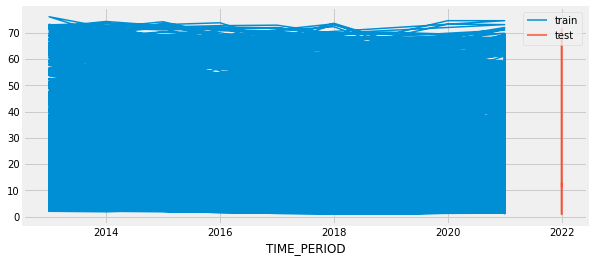

In [36]:
fig, ax=plt.subplots(figsize=(9, 4))
data_train['OBS_VALUE'].plot(ax=ax, label='train')
data_test['OBS_VALUE'].plot(ax=ax, label='test')
ax.legend();


In [38]:
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags = 6  # Using past 6 data points to forecast
                )

forecaster.fit(y=data_train['OBS_VALUE'])
steps = len(data_test)  # Number of steps to predict is equivalent to the size of the test data
predictions = forecaster.predict(steps=steps)
forecaster

ForecasterAutoreg 
Regressor: RandomForestRegressor(random_state=123) 
Lags: [1 2 3 4 5 6] 
Transformer for y: None 
Transformer for exog: None 
Window size: 6 
Weight function included: False 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [0, 11605] 
Training index type: RangeIndex 
Training index frequency: 1 
Regressor parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 123, 'verbose': 0, 'warm_start': False} 
Creation date: 2023-09-19 12:14:21 
Last fit date: 2023-09-19 12:14:27 
Skforecast version: 0.7.0 
Python version: 3.9.12 
Forecaster id: None 

In [39]:
# Predictions
# ==============================================================================
steps = 5
predictions = forecaster.predict(steps=steps)
predictions.head(5)

6     26.181000
7     24.724000
8     28.633000
9     31.257667
10    28.471000
Name: pred, dtype: float64

In [44]:
# Hyperparameter Grid search
# ==============================================================================
steps = 5
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123, bootstrap=True, n_jobs=-1),
                lags      = 6 # This value will be replaced in the grid search
             )

# Lags used as predictors (considering 2 to 6 years)
lags_grid = [2, 3, 4, 5, 6]

# Regressor's hyperparameters
# Reduced the hyperparameters for the sake of computational efficiency
param_grid = {'n_estimators': [100],
              'max_depth': [10],
             'max_samples':[0.8],
             }

# Using a subset of data for hyperparameter tuning
subset_data_train = data_train.sample(frac=0.3, random_state=123)

results_grid = grid_search_forecaster(
                        forecaster         = forecaster,
                        y                  = subset_data_train['OBS_VALUE'],
                        param_grid         = param_grid,
                        lags_grid          = lags_grid,
                        steps              = steps,
                        refit              = True,
                        metric             = 'mean_squared_error',
                        initial_train_size = int(len(subset_data_train)*0.5),
                        fixed_train_size   = False,
                        return_best        = True,
                        verbose            = False
               )


Number of models compared: 5.


loop lags_grid: 100%|██████████████████████████████████████| 5/5 [11:26<00:00, 137.30s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3] 
  Parameters: {'max_depth': 10, 'max_samples': 0.8, 'n_estimators': 100}
  Backtesting metric: 306.3355566006422



In [45]:
# Grid Search results
# ==============================================================================
results_grid

,lags,params,mean_squared_error,max_depth,max_samples,n_estimators
1,"[1, 2, 3]","{'max_depth': 10, 'max_samples': 0.8, 'n_estim...",306.335557,10.0,0.8,100.0
0,"[1, 2]","{'max_depth': 10, 'max_samples': 0.8, 'n_estim...",308.763692,10.0,0.8,100.0
2,"[1, 2, 3, 4]","{'max_depth': 10, 'max_samples': 0.8, 'n_estim...",309.177796,10.0,0.8,100.0
3,"[1, 2, 3, 4, 5]","{'max_depth': 10, 'max_samples': 0.8, 'n_estim...",309.665590,10.0,0.8,100.0
4,"[1, 2, 3, 4, 5, 6]","{'max_depth': 10, 'max_samples': 0.8, 'n_estim...",311.211112,10.0,0.8,100.0


Information of backtesting process
----------------------------------
Number of observations used for initial training: 13233
Number of observations used for backtesting: 45
    Number of folds: 9
    Number of steps per fold: 5

Data partition in fold: 0
    Training:   2013 -- 2021  (n=13233)
    Validation: 2022 -- 2022  (n=5)
Data partition in fold: 1
    Training:   2013 -- 2022  (n=13238)
    Validation: 2021 -- 2021  (n=5)
Data partition in fold: 2
    Training:   2013 -- 2021  (n=13243)
    Validation: 2022 -- 2022  (n=5)
Data partition in fold: 3
    Training:   2013 -- 2022  (n=13248)
    Validation: 2021 -- 2021  (n=5)
Data partition in fold: 4
    Training:   2013 -- 2021  (n=13253)
    Validation: 2022 -- 2022  (n=5)
Data partition in fold: 5
    Training:   2013 -- 2022  (n=13258)
    Validation: 2021 -- 2015  (n=5)
Data partition in fold: 6
    Training:   2013 -- 2015  (n=13263)
    Validation: 2016 -- 2020  (n=5)
Data partition in fold: 7
    Training:   2013 -- 2020  

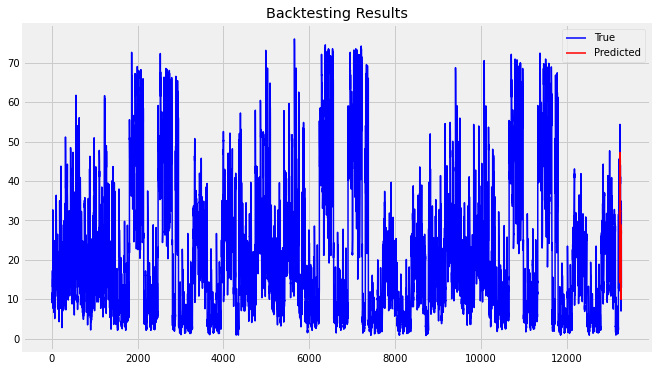

In [59]:
# Best model from the grid search
forecaster = ForecasterAutoreg(
    regressor=RandomForestRegressor(
        max_depth=10, 
        max_samples=0.8, 
        n_estimators=100, 
        random_state=123, 
        bootstrap=True, 
        n_jobs=-1
    ),
    lags=[1, 2, 3] # best lags determined from grid search
)

# Backtesting setup
steps = 5
n_backtesting = steps * 3 * 3  # Separate the last 9 cycles (assuming each cycle is 5 steps) for the backtest

metric, predictions_backtest = backtesting_forecaster(
    forecaster=forecaster,
    y=df['OBS_VALUE'],
    initial_train_size=len(df) - n_backtesting,
    fixed_train_size=False,
    steps=steps,
    metric='mean_squared_error',
    refit=True,
    verbose=True
)

print(f"Backtest error: {metric}")

# Plot the true vs predicted values for visual inspection.
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(df['OBS_VALUE'].values, label='True', color='blue') # Extracting .values from Series

# Extracting .values from predictions
plt.plot(range(len(df) - n_backtesting, len(df)), predictions_backtest.values, label='Predicted', color='red')
plt.legend()
plt.title('Backtesting Results')
plt.show()



In [61]:
forecaster.fit(y=data_train['OBS_VALUE'])

In [62]:
# Predictors importance
# ==============================================================================
importances = forecaster.get_feature_importance()
print(importances)


  feature  importance
0   lag_1    0.937123
1   lag_2    0.036148
2   lag_3    0.026729


### Final model

In [64]:
# Create and train forecaster with the best hyperparameters
# ==============================================================================
regressor = RandomForestRegressor(max_depth=3, n_estimators=500, random_state=123)
forecaster = ForecasterAutoreg(
                regressor = regressor,
                lags      = 1
             )

forecaster.fit(y=data_train['OBS_VALUE'])

In [65]:
predictions = forecaster.predict(steps=steps)

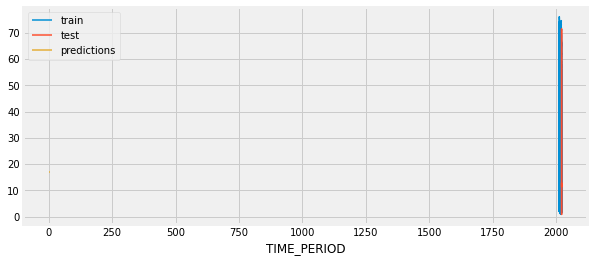

In [67]:
fig, ax=plt.subplots(figsize=(9, 4))
data_train['OBS_VALUE'].plot(ax=ax, label='train')
data_test['OBS_VALUE'].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();


In [69]:
predictions = forecaster.predict(steps=len(data_test))

In [70]:
error_mse = mean_squared_error(
                y_true=data_test['OBS_VALUE'],
                y_pred=predictions
            )
print(f"Test error (mse): {error_mse}")


Test error (mse): 308.6257305472873


In [72]:
rmse = np.sqrt(error_mse)
print(f"Test error (rmse): {rmse}")


Test error (rmse): 17.567746883060654
